In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from pyresample import geometry
import random
from skimage.transform import resize
from skimage.transform import resize_local_mean
import tensorflow as tf
import tensorflow_hub as hub
from skimage.filters import laplace
from skimage.filters import unsharp_mask
import skimage
import math

model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
random.seed(42)

In [29]:
x = resize(goes103, (250, 250))

In [31]:
x

array([[301.3683 , 303.42307, 303.18875, ..., 303.55142, 300.12827,
        298.38702],
       [302.279  , 303.603  , 303.21094, ..., 302.53503, 299.86728,
        298.40057],
       [301.87103, 301.633  , 301.46152, ..., 303.7744 , 301.89636,
        301.0938 ],
       ...,
       [284.67188, 284.74478, 284.8584 , ..., 260.47354, 276.78958,
        290.0451 ],
       [284.63477, 284.71796, 284.88638, ..., 274.05783, 286.35815,
        293.94916],
       [284.69385, 284.78387, 284.86566, ..., 279.4158 , 288.94852,
        290.20334]], dtype=float32)

Text(0.5, 1.0, 'resize_local_mean')

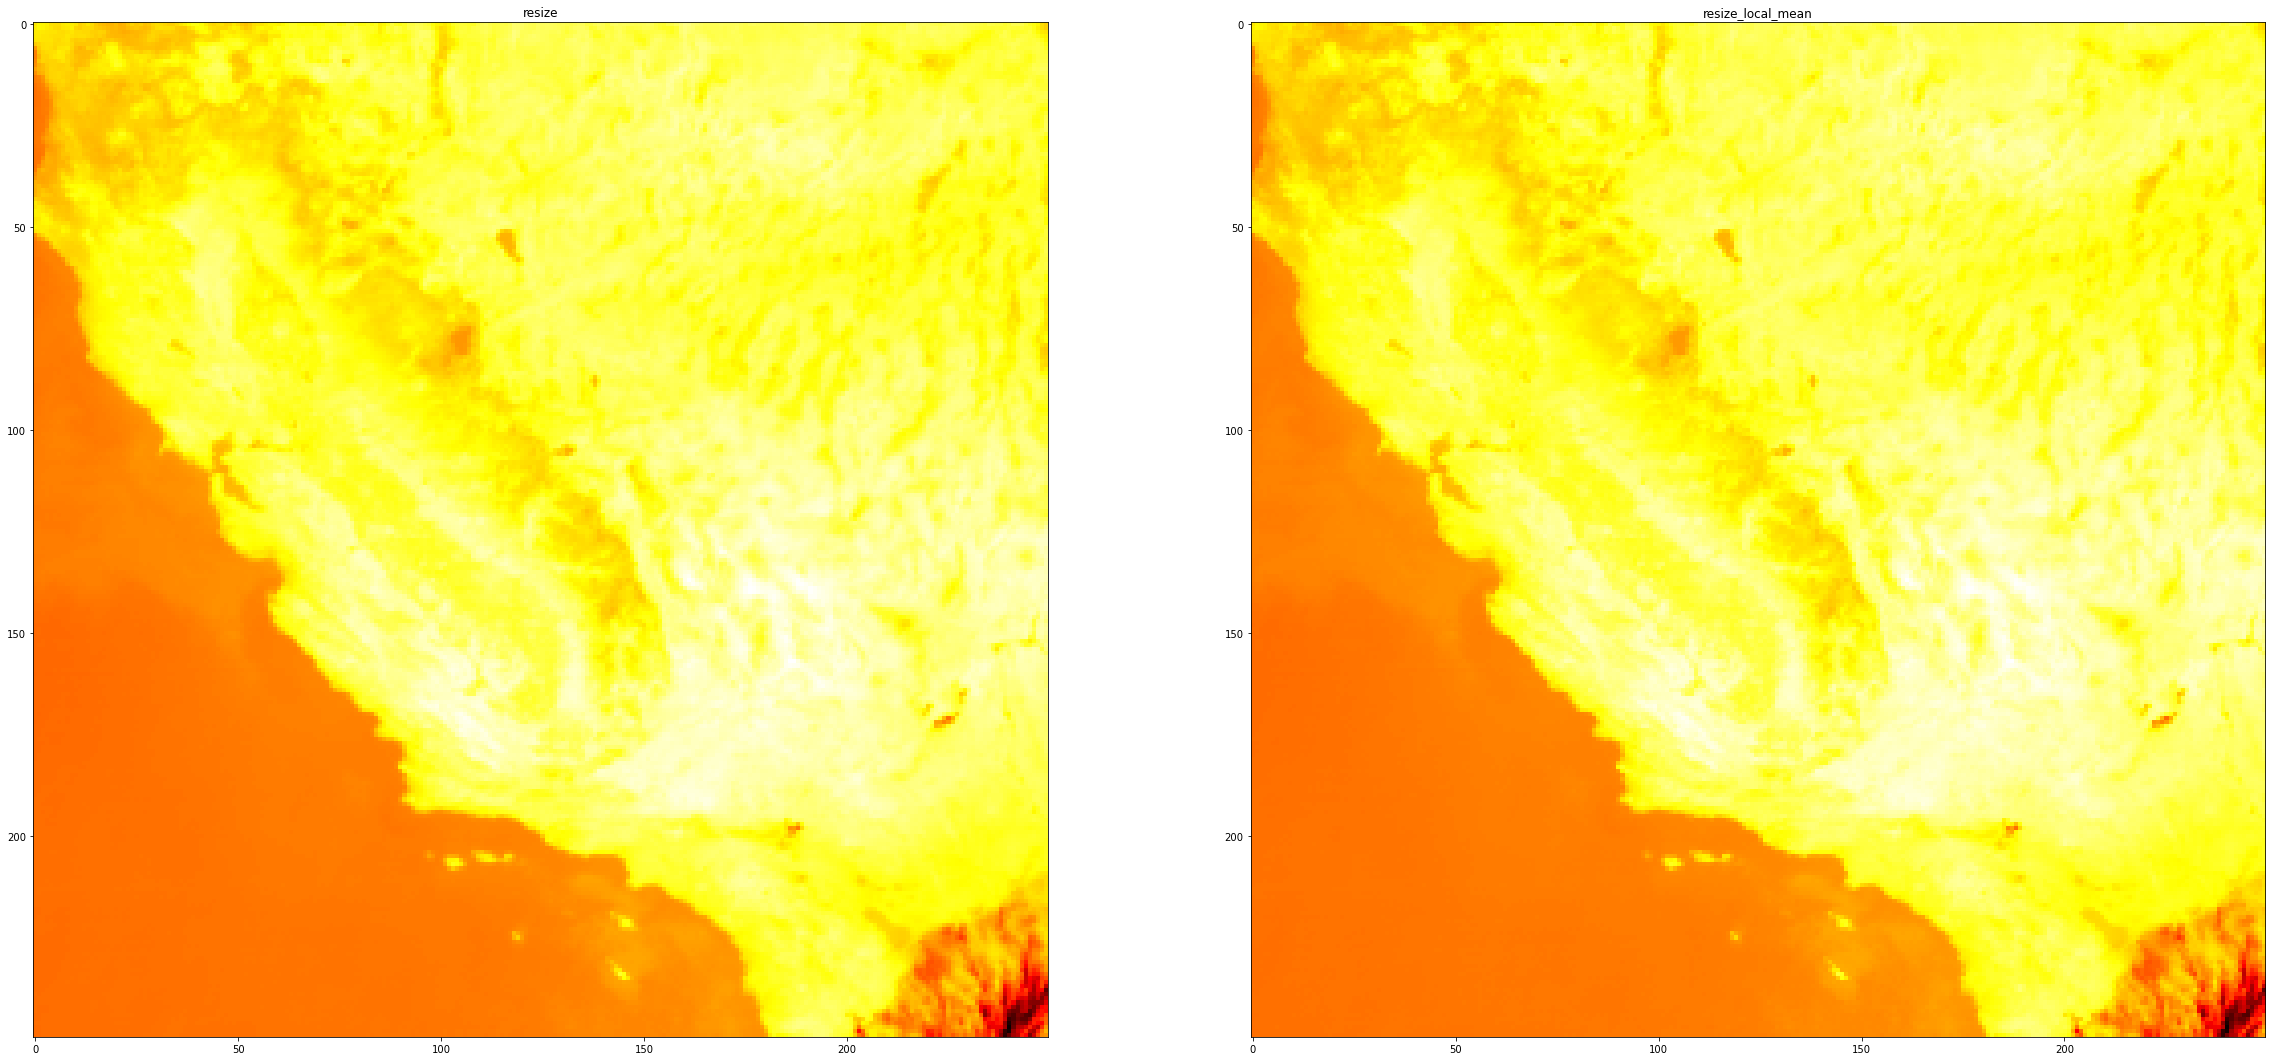

In [32]:
f, ax = plt.subplots(1, 2, figsize=(40, 25))

ax[0].imshow(resize(goes103, (250, 250)), cmap='hot')
ax[0].set_title('resize')
ax[1].imshow(resize_local_mean(goes103, (250, 250)), cmap='hot')
ax[1].set_title('resize_local_mean')

In [23]:
def shiftPixels(refimg, newimg_full, min_x, min_y, lats=None, lons=None):
    assert refimg.shape[0] <= newimg_full.shape[0]
    assert refimg.shape[1] <= newimg_full.shape[1]
    
    if lats != None or lons != None:
        newimg = newimg_full[lats[0]:lats[1], lons[0]:lons[1]]
    else:
        newimg = newimg_full.copy()
    
    nx = 0
    ny = 0
    
    while refimg.shape != newimg.shape:
        x_add = 0
        y_add = 0
        
        if refimg.shape[0] > newimg.shape[0]:
            x_add += 1
            nx += 1
        elif refimg.shape[0] < newimg.shape[0]:
            x_add -= 1
            nx += 1
        if refimg.shape[1] > newimg.shape[1]:
            y_add += 1
            ny += 1
        elif refimg.shape[1] < newimg.shape[1]:
            y_add -= 1
            ny += 1
        
        if lats != None or lons != None:
            newimg = newimg_full[lats[0]:lats[1] + nx, lons[0]:lons[1] + ny]
        else:
            newimg = newimg_full[:(newimg.shape[0] + x_add), :(newimg.shape[1] + y_add)]
    
    if lats != None or lons != None:
        lats[1] += x_add
        lons[1] += y_add

    if lats != None or lons != None:
        return newimg_full[lats[0]+min_x:lats[1]+min_x+1, lons[0]+min_y:lons[1]+min_y+1]
    return newimg_full[abs(min_x):(newimg.shape[0] + abs(min_x)), abs(min_y):(newimg.shape[1] + abs(min_y))]

def expand(refimg, newimg_full, min_x, min_y, lats, lons):
    newimg = newimg_full[lats[0]:lats[1], lons[0]:lons[1]]
    
    nx = 0
    ny = 0
    
    x_add = 0
    y_add = 0
    
    while refimg.shape != newimg.shape:
        x_add = 0
        y_add = 0
    
        if refimg.shape[0] > newimg.shape[0]:
            x_add += 1
            nx += 1
        elif refimg.shape[0] < newimg.shape[0]:
            x_add -= 1
            nx += 1
        if refimg.shape[1] > newimg.shape[1]:
            y_add += 1
            ny += 1
        elif refimg.shape[1] < newimg.shape[1]:
            y_add -= 1
            ny += 1
        newimg = newimg_full[lats[0]:lats[1] + nx, lons[0]:lons[1] + ny]

    lats[1] += x_add
    lons[1] += y_add

    return newimg_full[lats[0]+min_x-1:lats[1]+min_x+2, lons[0]+min_y-1:lons[1]+min_y+2]

In [7]:
def control_img(img):
    height, width = img.shape
    control = resize_local_mean(img, (2*height, 2*width))
    return control

def laplace_sharpening_img(img):
    height, width = img.shape
    blurryimg = resize_local_mean(img, (2*height, 2*width))
    laplace_edges = laplace(blurryimg)
    sharpimg = blurryimg + 0.8*laplace_edges
    return sharpimg

def unsharpmask_sharpening_img(img):
    height, width = img.shape
    blurryimg = resize_local_mean(img, (2*height, 2*width))
    sharpimg = unsharp_mask(blurryimg/blurryimg.max(), radius=1, amount=1)*blurryimg.max()
    return sharpimg

In [8]:
def load_image(array):
    result = np.zeros((array.shape[0], array.shape[1], 3))
    result[:,:,0]= array
    result[:,:,1]= array
    result[:,:,2]= array
    return result

def preprocess_image(array):
    hr_image = array
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 2) * 2
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

def downscale_image(image):
    height, width = image.shape
    result = np.zeros((image.shape[0]//2, image.shape[1]//2, 3))
    smallimg = resize_local_mean(image, (round(height/2), round(width/2)))
    result[:,:,0] = smallimg
    result[:,:,1] = smallimg
    result[:,:,2] = smallimg
    lr_image = tf.expand_dims(result, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

def esrgan_sharpening_img(image):
    hr_image = preprocess_image(load_image(image))
    lr_image = downscale_image(image)
    
    fake_image = model(lr_image)
    fake_image = tf.squeeze(fake_image)
    
    hr_image = tf.squeeze(hr_image).numpy()
    lr_image = tf.squeeze(lr_image).numpy()
    return np.mean(fake_image, axis=2)

In [9]:
def z_score(img):
    return np.log(np.abs(((img-img.mean())/img.std())))

In [10]:
def dice_score(x, y):
    numerator = 2*np.count_nonzero(np.logical_and(x, y))
    denominator = np.count_nonzero(x) + np.count_nonzero(y)
    return numerator/denominator

In [11]:
landsat_path = '../landsat_files/landsat_files/'
goes_path = '../landsat_files/'
goes039 = np.load(goes_path + 'OR_ABI-L1b-RadC-M6C07_G17_s20212401846176_e20212401848561_c20212401849003.npy')
goes103 = np.load(goes_path + 'OR_ABI-L1b-RadC-M6C14_G17_s20212401846176_e20212401848549_c20212401848593.npy')

pc = ccrs.PlateCarree()
pc_params = pc.proj4_params
pc_extents = [-124.25, 32.25, -114.25, 42.25]
shape = [500, 500]
target_area = geometry.AreaDefinition.from_extent('CA', pc_params, shape, pc_extents)

latlon1A = [40.49, -121.45]
latlon2A = [40.650000000000006, -121.17]
coords1A = target_area.get_array_coordinates_from_lonlat(latlon1A[1], latlon1A[0])
coords1A = (round(coords1A[0]), round(coords1A[1]))
coords2A = target_area.get_array_coordinates_from_lonlat(latlon2A[1], latlon2A[0])
coords2A = (round(coords2A[0]), round(coords2A[1]))
lonsA = [coords1A[0], coords2A[0]]
latsA = [coords2A[1], coords1A[1]]

latlon1B = [39.91, -120.97]
latlon2B = [40.13, -120.49000000000001]
coords1B = target_area.get_array_coordinates_from_lonlat(latlon1B[1], latlon1B[0])
coords1B = (round(coords1B[0]), round(coords1B[1]))
coords2B = target_area.get_array_coordinates_from_lonlat(latlon2B[1], latlon2B[0])
coords2B = (round(coords2B[0]), round(coords2B[1]))
lonsB = [coords1B[0], coords2B[0]]
latsB = [coords2B[1], coords1B[1]]

In [12]:
goes_fire_mask = np.load(goes_path + 'OR_ABI-L2-FDCC-M6_G17_s20212401846176_e20212401848549_c20212401849146.npy')
goes_fire_mask[goes_fire_mask >= 100] = 0

## SR on Full GOES

In [13]:
pc = ccrs.PlateCarree()
pc_params = pc.proj4_params
pc_extents = [-124.25, 32.25, -114.25, 42.25]
shape = [1000, 1000]
target_area = geometry.AreaDefinition.from_extent('CA', pc_params, shape, pc_extents)

latlon1A = [40.49, -121.45]
latlon2A = [40.650000000000006, -121.17]
coords1A = target_area.get_array_coordinates_from_lonlat(latlon1A[1], latlon1A[0])
coords1A = (round(coords1A[0]), round(coords1A[1]))
coords2A = target_area.get_array_coordinates_from_lonlat(latlon2A[1], latlon2A[0])
coords2A = (round(coords2A[0]), round(coords2A[1]))
lonsA = [coords1A[0], coords2A[0]]
latsA = [coords2A[1], coords1A[1]]

latlon1B = [39.91, -120.97]
latlon2B = [40.13, -120.49000000000001]
coords1B = target_area.get_array_coordinates_from_lonlat(latlon1B[1], latlon1B[0])
coords1B = (round(coords1B[0]), round(coords1B[1]))
coords2B = target_area.get_array_coordinates_from_lonlat(latlon2B[1], latlon2B[0])
coords2B = (round(coords2B[0]), round(coords2B[1]))
lonsB = [coords1B[0], coords2B[0]]
latsB = [coords2B[1], coords1B[1]]

In [14]:
new_landsat_039_A = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridAcent0.01deg.npy'))
new_landsat_103_A = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridAcent0.01deg.npy'))
new_landsat_diff_A = new_landsat_039_A - new_landsat_103_A

new_landsat_039_B = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridBcent0.01deg.npy'))
new_landsat_103_B = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridBcent0.01deg.npy'))
new_landsat_diff_B = new_landsat_039_B - new_landsat_103_B

new_goes_039_full = esrgan_sharpening_img(goes039)
new_goes_103_full = esrgan_sharpening_img(goes103)
new_goes_diff_full = new_goes_039_full - new_goes_103_full

new_goes_039_A_full = shiftPixels(new_landsat_039_A, new_goes_039_full, -1, 0, [latsA[0], latsA[1]], [lonsA[0], lonsA[1]])
new_goes_103_A_full = shiftPixels(new_landsat_103_A, new_goes_103_full, -1, 0, [latsA[0], latsA[1]], [lonsA[0], lonsA[1]])
new_goes_diff_A_full = new_goes_039_A_full - new_goes_103_A_full

new_goes_039_B_full = shiftPixels(new_landsat_039_B, new_goes_039_full, -1, 0, [latsB[0], latsB[1]], [lonsB[0], lonsB[1]])
new_goes_103_B_full = shiftPixels(new_landsat_103_B, new_goes_103_full, -1, 0, [latsB[0], latsB[1]], [lonsB[0], lonsB[1]])
new_goes_diff_B_full = new_goes_039_B_full - new_goes_103_B_full

2022-07-06 13:59:35.530447: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-06 13:59:35.632384: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400210000 Hz


Text(0.5, 1.0, 'GOES Image B')

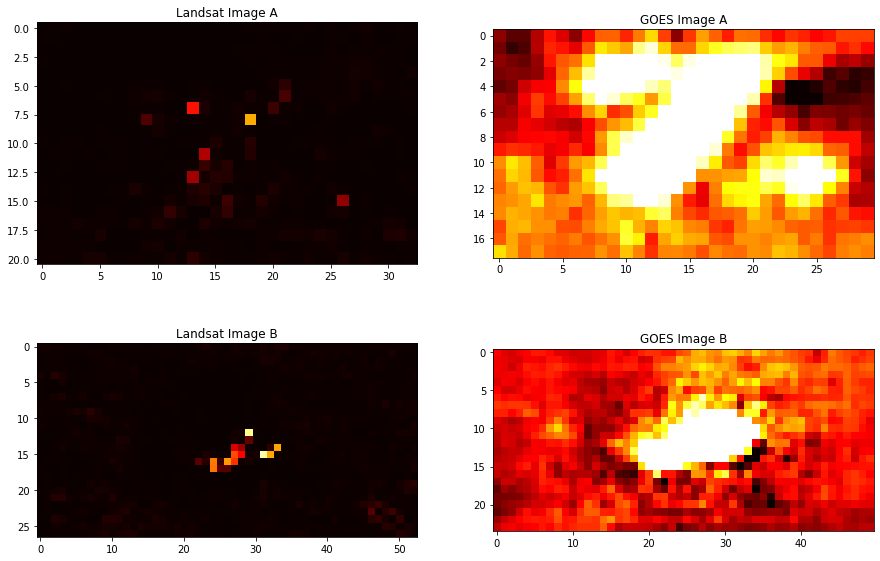

In [15]:
f, (ax1, ax2) = plt.subplots(2, 2, figsize=(15, 10))
max_temp = 10
min_temp = 0
ax1[0].imshow(new_landsat_diff_A, vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[0].set_title('Landsat Image A')
ax1[1].imshow(new_goes_diff_A_full, vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[1].set_title('GOES Image A')
# plt.colorbar(landsat_map, ax = ax2, shrink=0.25)
ax2[0].imshow(new_landsat_diff_B, vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[0].set_title('Landsat Image B')
ax2[1].imshow(new_goes_diff_B_full, vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[1].set_title('GOES Image B')

## SR on Cropped GOES

In [25]:
landsat_img_039_A = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridAcent0.02deg.npy'))
landsat_img_103_A = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridAcent0.02deg.npy'))
new_landsat_img_039_A = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridAcent0.01deg.npy'))
new_landsat_img_103_A = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridAcent0.01deg.npy'))
new_landsat_diff_A = new_landsat_img_039_A - new_landsat_img_103_A

goes_img_expanded_039_A = expand(landsat_img_039_A, goes039, -1, 0, [latsA[0], latsA[1]], [lonsA[0], lonsA[1]])
goes_img_expanded_103_A = expand(landsat_img_103_A, goes103, -1, 0, [latsA[0], latsA[1]], [lonsA[0], lonsA[1]])

esrgan_goes_img_039_A = shiftPixels(new_landsat_img_039_A, esrgan_sharpening_img(goes_img_expanded_039_A), 0, 0)
esrgan_goes_img_103_A = shiftPixels(new_landsat_img_103_A, esrgan_sharpening_img(goes_img_expanded_103_A), 0, 0)
esrgan_goes_diff_A = esrgan_goes_img_039_A - esrgan_goes_img_103_A

laplace_goes_img_039_A = shiftPixels(new_landsat_img_039_A, laplace_sharpening_img(goes_img_expanded_039_A), 0, 0)
laplace_goes_img_103_A = shiftPixels(new_landsat_img_103_A, laplace_sharpening_img(goes_img_expanded_103_A), 0, 0)
laplace_goes_diff_A = laplace_goes_img_039_A - laplace_goes_img_103_A

unsharpmask_goes_img_039_A = shiftPixels(new_landsat_img_039_A, unsharpmask_sharpening_img(goes_img_expanded_039_A), 0, 0)
unsharpmask_goes_img_103_A = shiftPixels(new_landsat_img_103_A, unsharpmask_sharpening_img(goes_img_expanded_103_A), 0, 0)
unsharpmask_goes_diff_A = unsharpmask_goes_img_039_A - unsharpmask_goes_img_103_A

control_goes_img_039_A = shiftPixels(new_landsat_img_039_A, control_img(goes_img_expanded_039_A), 0, 0)
control_goes_img_103_A = shiftPixels(new_landsat_img_103_A, control_img(goes_img_expanded_103_A), 0, 0)
control_goes_diff_A = control_goes_img_039_A - control_goes_img_103_A

KeyboardInterrupt: 

In [22]:
landsat_img_039_B = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridBcent0.02deg.npy'))[:12, :26]
landsat_img_103_B = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridBcent0.02deg.npy'))[:12, :26]
new_landsat_img_039_B = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridBcent0.01deg.npy'))
new_landsat_img_103_B = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridBcent0.01deg.npy'))
new_landsat_diff_B = new_landsat_img_039_B - new_landsat_img_103_B

goes_img_expanded_039_B = expand(landsat_img_039_B, goes039, -1, 0, [latsB[0], latsB[1]], [lonsB[0], lonsB[1]])
goes_img_expanded_103_B = expand(landsat_img_103_B, goes103, -1, 0, [latsB[0], latsB[1]], [lonsB[0], lonsB[1]])

esrgan_goes_img_039_B = shiftPixels(new_landsat_img_039_B, esrgan_sharpening_img(goes_img_expanded_039_B), 0, -1)
esrgan_goes_img_103_B = shiftPixels(new_landsat_img_103_B, esrgan_sharpening_img(goes_img_expanded_103_B), 0, -1)
esrgan_goes_diff_B = esrgan_goes_img_039_B - esrgan_goes_img_103_B

laplace_goes_img_039_B = shiftPixels(new_landsat_img_039_B, laplace_sharpening_img(goes_img_expanded_039_B), 0, 0)
laplace_goes_img_103_B = shiftPixels(new_landsat_img_103_B, laplace_sharpening_img(goes_img_expanded_103_B), 0, 0)
laplace_goes_diff_B = laplace_goes_img_039_B - laplace_goes_img_103_B

unsharpmask_goes_img_039_B = shiftPixels(new_landsat_img_039_B, unsharpmask_sharpening_img(goes_img_expanded_039_B), 0, 0)
unsharpmask_goes_img_103_B = shiftPixels(new_landsat_img_103_B, unsharpmask_sharpening_img(goes_img_expanded_103_B), 0, 0)
unsharpmask_goes_diff_B = unsharpmask_goes_img_039_B - unsharpmask_goes_img_103_B

control_goes_img_039_B = shiftPixels(new_landsat_img_039_B, control_img(goes_img_expanded_039_B), 0, 0)
control_goes_img_103_B = shiftPixels(new_landsat_img_103_B, control_img(goes_img_expanded_103_B), 0, 0)
control_goes_diff_B = control_goes_img_039_B - control_goes_img_103_B

KeyboardInterrupt: 

In [ ]:
print("0.01 deg")

f, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 5))
max_temp = 3
min_temp = 0

ax1[0].imshow(z_score(new_landsat_diff_A), vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[0].set_title('Landsat Image A')
ax1[1].imshow(z_score(esrgan_goes_diff_A), vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[1].set_title('ESRGAN GOES Image A')
ax1[2].imshow(z_score(laplace_goes_diff_A), vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[2].set_title('Laplace GOES Image A')
ax1[3].imshow(z_score(unsharpmask_goes_diff_A), vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[3].set_title('Unsharp Mask GOES Image A')
ax1[4].imshow(z_score(control_goes_diff_A), vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[4].set_title('Control GOES Image A')
# plt.colorbar(landsat_map, ax = ax2, shrink=0.25)
ax2[0].imshow(z_score(new_landsat_diff_B), vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[0].set_title('Landsat Image B')
ax2[1].imshow(z_score(esrgan_goes_diff_B), vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[1].set_title('ESRGAN GOES Image B')
ax2[2].imshow(z_score(laplace_goes_diff_B), vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[2].set_title('Laplace GOES Image B')
ax2[3].imshow(z_score(unsharpmask_goes_diff_B), vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[3].set_title('Unsharp Mask GOES Image B')
ax2[4].imshow(z_score(control_goes_diff_B), vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[4].set_title('Control GOES Image B')

In [ ]:
print("0.01 deg")

f, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 5))
max_temp = 3
min_temp = 0

ax1[0].imshow(z_score(new_landsat_img_103_A), vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[0].set_title('Landsat Image A')
ax1[1].imshow(z_score(esrgan_goes_img_103_A), vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[1].set_title('ESRGAN GOES Image A')
ax1[2].imshow(z_score(laplace_goes_img_103_A), vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[2].set_title('Laplace GOES Image A')
ax1[3].imshow(z_score(unsharpmask_goes_img_103_A), vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[3].set_title('Unsharp Mask GOES Image A')
ax1[4].imshow(z_score(control_goes_img_103_A), vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[4].set_title('Control GOES Image A')
# plt.colorbar(landsat_map, ax = ax2, shrink=0.25)
ax2[0].imshow(z_score(new_landsat_img_103_B), vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[0].set_title('Landsat Image B')
ax2[1].imshow(z_score(esrgan_goes_img_103_B), vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[1].set_title('ESRGAN GOES Image B')
ax2[2].imshow(z_score(laplace_goes_img_103_B), vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[2].set_title('Laplace GOES Image B')
ax2[3].imshow(z_score(unsharpmask_goes_img_103_B), vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[3].set_title('Unsharp Mask GOES Image B')
ax2[4].imshow(z_score(control_goes_img_103_B), vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[4].set_title('Control GOES Image B')

In [ ]:
def results(refimg, img, title):
    print(title + " correlation coefficient: " + str(np.corrcoef(refimg.ravel(), img.ravel())[0, 1]))
    print(title + " rmse: " + str(math.sqrt(np.square(refimg - img).mean())))
    return [np.corrcoef(refimg, img).mean(), math.sqrt(np.square(refimg - img).mean())/50]

In [ ]:
titles = ['ESRGAN', 'Laplace', 'Unsharp Mask', 'Control']
corrcoeffsA = []
corrcoeffsB = []
rmseA = []
rmseB = []

print('Subset A')
dataA = []
statsA = [esrgan_goes_diff_A, laplace_goes_diff_A, unsharpmask_goes_diff_A, control_goes_diff_A]
for n in range(len(titles)):
    stats = results(new_landsat_diff_A, statsA[n], titles[n])
    corrcoeffsA.append(stats[0])
    rmseA.append(stats[1])

print('')
    
print('Subset B')
dataB = []
statsB = [esrgan_goes_diff_B, laplace_goes_diff_B, unsharpmask_goes_diff_B, control_goes_diff_B]
for n in range(len(titles)):
    stats = results(new_landsat_diff_B, statsB[n], titles[n])
    corrcoeffsB.append(stats[0])
    rmseB.append(stats[1])

In [ ]:
X = np.arange(4)
fig = plt.subplots(figsize =(12, 8))
barWidth = 0.25

plt.bar(X + 0.00, corrcoeffsA, color ='b', width = barWidth, edgecolor ='grey', label ='Correlation Coefficient')
plt.bar(X + 0.25, rmseA, color ='g', width = barWidth, edgecolor ='grey', label ='RMSE/50')

plt.title('Subset A')
plt.xlabel('Stats', fontweight ='bold', fontsize = 15)
plt.ylabel('Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(titles))], ['ESRGAN', 'Laplace', 'Unsharp Mask', 'Control'])
 
plt.legend()
plt.show()

In [ ]:
X = np.arange(4)
fig = plt.subplots(figsize =(12, 8))
barWidth = 0.25

plt.bar(X + 0.00, corrcoeffsB, color ='b', width = barWidth, edgecolor ='grey', label ='Correlation Coefficient')
plt.bar(X + 0.25, rmseB, color ='g', width = barWidth, edgecolor ='grey', label ='RMSE/50')

plt.title('Subset B')
plt.xlabel('Stats', fontweight ='bold', fontsize = 15)
plt.ylabel('Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(titles))], ['ESRGAN', 'Laplace', 'Unsharp Mask', 'Control'])
 
plt.legend()
plt.show()

In [ ]:
goes_img_original_039_A = esrgan_sharpening_img(goes_img_expanded_039_A)
goes_img_original_103_A = esrgan_sharpening_img(goes_img_expanded_103_A)

goes_img_original_039_B = esrgan_sharpening_img(goes_img_expanded_039_B)
goes_img_original_103_B = esrgan_sharpening_img(goes_img_expanded_103_B)

In [ ]:
landsat_img_039_A = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridAcent0.01deg.npy'))
landsat_img_103_A = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridAcent0.01deg.npy'))
new_landsat_img_039_A = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridAcent0.005deg.npy'))
new_landsat_img_103_A = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridAcent0.005deg.npy'))

landsat_img_039_B = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridBcent0.01deg.npy'))
landsat_img_103_B = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridBcent0.01deg.npy'))
new_landsat_img_039_B = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridBcent0.005deg.npy'))
new_landsat_img_103_B = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridBcent0.005deg.npy'))

In [ ]:
goes_img_original_039_A = esrgan_sharpening_img(goes_img_original_039_A)
goes_img_original_103_A = esrgan_sharpening_img(goes_img_original_103_A)

new_landsat_diff_A = new_landsat_img_039_A - new_landsat_img_103_A
new_goes_img_039_A = shiftPixels(new_landsat_img_039_A, goes_img_original_039_A, 0, -1)
new_goes_img_103_A = shiftPixels(new_landsat_img_103_A, goes_img_original_103_A, 0, -1)
new_goes_diff_A = new_goes_img_039_A - new_goes_img_103_A

goes_img_original_039_B = esrgan_sharpening_img(goes_img_original_039_B)
goes_img_original_103_B = esrgan_sharpening_img(goes_img_original_103_B)

new_landsat_diff_B = new_landsat_img_039_B - new_landsat_img_103_B
new_goes_img_039_B = shiftPixels(new_landsat_img_039_B, goes_img_original_039_B, 0, -1)
new_goes_img_103_B = shiftPixels(new_landsat_img_103_B, goes_img_original_103_B, 0, -1)
new_goes_diff_B = new_goes_img_039_B - new_goes_img_103_B

In [ ]:
print("0.005 deg")

f, (ax1, ax2) = plt.subplots(2, 2, figsize=(15, 10))
max_temp = 65
min_temp = 0
ax1[0].imshow(new_landsat_diff_A, vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[0].set_title('Landsat Image A')
ax1[1].imshow(new_goes_diff_A, vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[1].set_title('GOES Image A')
# plt.colorbar(landsat_map, ax = ax2, shrink=0.25)
ax2[0].imshow(new_landsat_diff_B, vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[0].set_title('Landsat Image B')
ax2[1].imshow(new_goes_diff_B, vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[1].set_title('GOES Image B')

In [ ]:
landsat_img_039_A = z_score(np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridAcent0.02deg.npy')))
landsat_img_103_A = z_score(np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridAcent0.02deg.npy')))
new_landsat_img_039_A = z_score(np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridAcent0.01deg.npy')))
new_landsat_img_103_A = z_score(np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridAcent0.01deg.npy')))
new_landsat_diff_A = new_landsat_img_039_A - new_landsat_img_103_A

goes_img_expanded_039_A = z_score(expand(landsat_img_039_A, goes039, -1, 0, [latsA[0], latsA[1]], [lonsA[0], lonsA[1]]))
goes_img_expanded_103_A = z_score(expand(landsat_img_103_A, goes103, -1, 0, [latsA[0], latsA[1]], [lonsA[0], lonsA[1]]))

esrgan_goes_img_039_A = shiftPixels(new_landsat_img_039_A, esrgan_sharpening_img(goes_img_expanded_039_A), 0, 0)
esrgan_goes_img_103_A = shiftPixels(new_landsat_img_103_A, esrgan_sharpening_img(goes_img_expanded_103_A), 0, 0)
esrgan_goes_diff_A = esrgan_goes_img_039_A - esrgan_goes_img_103_A

laplace_goes_img_039_A = shiftPixels(new_landsat_img_039_A, laplace_sharpening_img(goes_img_expanded_039_A), 0, 0)
laplace_goes_img_103_A = shiftPixels(new_landsat_img_103_A, laplace_sharpening_img(goes_img_expanded_103_A), 0, 0)
laplace_goes_diff_A = laplace_goes_img_039_A - laplace_goes_img_103_A

unsharpmask_goes_img_039_A = shiftPixels(new_landsat_img_039_A, unsharpmask_sharpening_img(goes_img_expanded_039_A), 0, 0)
unsharpmask_goes_img_103_A = shiftPixels(new_landsat_img_103_A, unsharpmask_sharpening_img(goes_img_expanded_103_A), 0, 0)
unsharpmask_goes_diff_A = unsharpmask_goes_img_039_A - unsharpmask_goes_img_103_A

control_goes_img_039_A = shiftPixels(new_landsat_img_039_A, control_img(goes_img_expanded_039_A), 0, 0)
control_goes_img_103_A = shiftPixels(new_landsat_img_103_A, control_img(goes_img_expanded_103_A), 0, 0)
control_goes_diff_A = control_goes_img_039_A - control_goes_img_103_A

In [ ]:
landsat_img_039_B = z_score(np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridBcent0.02deg.npy'))[:12, :26])
landsat_img_103_B = z_score(np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridBcent0.02deg.npy'))[:12, :26])
new_landsat_img_039_B = z_score(np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridBcent0.01deg.npy')))
new_landsat_img_103_B = z_score(np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridBcent0.01deg.npy')))
new_landsat_diff_B = new_landsat_img_039_B - new_landsat_img_103_B

goes_img_expanded_039_B = z_score(expand(landsat_img_039_B, goes039, -1, 0, [latsB[0], latsB[1]], [lonsB[0], lonsB[1]]))
goes_img_expanded_103_B = z_score(expand(landsat_img_103_B, goes103, -1, 0, [latsB[0], latsB[1]], [lonsB[0], lonsB[1]]))

esrgan_goes_img_039_B = shiftPixels(new_landsat_img_039_B, esrgan_sharpening_img(goes_img_expanded_039_B), 0, -1)
esrgan_goes_img_103_B = shiftPixels(new_landsat_img_103_B, esrgan_sharpening_img(goes_img_expanded_103_B), 0, -1)
esrgan_goes_diff_B = esrgan_goes_img_039_B - esrgan_goes_img_103_B

laplace_goes_img_039_B = shiftPixels(new_landsat_img_039_B, laplace_sharpening_img(goes_img_expanded_039_B), 0, 0)
laplace_goes_img_103_B = shiftPixels(new_landsat_img_103_B, laplace_sharpening_img(goes_img_expanded_103_B), 0, 0)
laplace_goes_diff_B = laplace_goes_img_039_B - laplace_goes_img_103_B

unsharpmask_goes_img_039_B = shiftPixels(new_landsat_img_039_B, unsharpmask_sharpening_img(goes_img_expanded_039_B), 0, 0)
unsharpmask_goes_img_103_B = shiftPixels(new_landsat_img_103_B, unsharpmask_sharpening_img(goes_img_expanded_103_B), 0, 0)
unsharpmask_goes_diff_B = unsharpmask_goes_img_039_B - unsharpmask_goes_img_103_B

control_goes_img_039_B = shiftPixels(new_landsat_img_039_B, control_img(goes_img_expanded_039_B), 0, 0)
control_goes_img_103_B = shiftPixels(new_landsat_img_103_B, control_img(goes_img_expanded_103_B), 0, 0)
control_goes_diff_B = control_goes_img_039_B - control_goes_img_103_B

In [ ]:
print("0.01 deg")

f, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 5))
max_temp = 3
min_temp = 0

ax1[0].imshow(new_landsat_img_103_A, vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[0].set_title('Landsat Image A')
ax1[1].imshow(esrgan_goes_img_103_A, vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[1].set_title('ESRGAN GOES Image A')
ax1[2].imshow(laplace_goes_img_103_A, vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[2].set_title('Laplace GOES Image A')
ax1[3].imshow(unsharpmask_goes_img_103_A, vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[3].set_title('Unsharp Mask GOES Image A')
ax1[4].imshow(control_goes_img_103_A, vmin = min_temp, vmax = max_temp, cmap='hot')
ax1[4].set_title('Control GOES Image A')
# plt.colorbar(landsat_map, ax = ax2, shrink=0.25)
ax2[0].imshow(new_landsat_img_103_B, vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[0].set_title('Landsat Image B')
ax2[1].imshow(esrgan_goes_img_103_B, vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[1].set_title('ESRGAN GOES Image B')
ax2[2].imshow(laplace_goes_img_103_B, vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[2].set_title('Laplace GOES Image B')
ax2[3].imshow(unsharpmask_goes_img_103_B, vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[3].set_title('Unsharp Mask GOES Image B')
ax2[4].imshow(control_goes_img_103_B, vmin = min_temp, vmax = max_temp, cmap='hot')
ax2[4].set_title('Control GOES Image B')

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(20, 5))
max_temp = 3
min_temp = 0

ax.imshow(goes_img_expanded_103_B, vmin = min_temp, vmax = max_temp, cmap='hot')
ax.set_title('goes_img_expanded_103_B')

In [ ]:
titles = ['ESRGAN', 'Laplace', 'Unsharp Mask', 'Control']
corrcoeffsA = []
corrcoeffsB = []
rmseA = []
rmseB = []

print('Subset A')
dataA = []
statsA = [esrgan_goes_diff_A, laplace_goes_diff_A, unsharpmask_goes_diff_A, control_goes_diff_A]
for n in range(len(titles)):
    stats = results(new_landsat_diff_A, statsA[n], titles[n])
    corrcoeffsA.append(stats[0])
    rmseA.append(stats[1])

print('')
    
print('Subset B')
dataB = []
statsB = [esrgan_goes_diff_B, laplace_goes_diff_B, unsharpmask_goes_diff_B, control_goes_diff_B]
for n in range(len(titles)):
    stats = results(new_landsat_diff_B, statsB[n], titles[n])
    corrcoeffsB.append(stats[0])
    rmseB.append(stats[1])

In [ ]:
X = np.arange(4)
fig = plt.subplots(figsize =(12, 8))
barWidth = 0.25

plt.bar(X + 0.00, corrcoeffsA, color ='b', width = barWidth, edgecolor ='grey', label ='Correlation Coefficient')
plt.bar(X + 0.25, rmseA, color ='g', width = barWidth, edgecolor ='grey', label ='RMSE/50')

plt.title('Subset A')
plt.xlabel('Stats', fontweight ='bold', fontsize = 15)
plt.ylabel('Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(titles))], ['ESRGAN', 'Laplace', 'Unsharp Mask', 'Control'])
 
plt.legend()
plt.show()

In [ ]:
X = np.arange(4)
fig = plt.subplots(figsize =(12, 8))
barWidth = 0.25

plt.bar(X + 0.00, corrcoeffsB, color ='b', width = barWidth, edgecolor ='grey', label ='Correlation Coefficient')
plt.bar(X + 0.25, rmseB, color ='g', width = barWidth, edgecolor ='grey', label ='RMSE/50')

plt.title('Subset B')
plt.xlabel('Stats', fontweight ='bold', fontsize = 15)
plt.ylabel('Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(titles))], ['ESRGAN', 'Laplace', 'Unsharp Mask', 'Control'])
 
plt.legend()
plt.show()